# Final Project Text Mining

## NERC

### Importing Packages

In [2]:
import pandas as pd
import numpy as np
import re
import collections
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.metrics import flat_f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import eli5
import nltk
from nltk.tokenize import word_tokenize
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Read Dataset

In [3]:
data_train = pd.read_csv("nerc_datasets/kaggle/ner_dataset.csv", encoding="latin1")

In [4]:
data_train

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


### Fill the NaN values

In [5]:
data_train = data_train.fillna(method="ffill")

In [6]:
data_train

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


### Checking Null Values

In [7]:
np.sum(data_train.isnull())

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

### Checking Number of Words

In [8]:
words = list(set(data_train["Word"].values))

In [9]:
num_words = len(words)
num_words

35178

### Checking Number of Sentences

In [10]:
data_train["Sentence #"].nunique()

47959

### Checking Unique POS labels

In [11]:
pos_values = list(set(data_train["POS"].values))
print(pos_values)

[',', '.', 'VBG', 'JJR', 'EX', 'TO', 'VBZ', 'NNP', 'JJ', 'WRB', 'PRP$', 'MD', 'WP', 'PRP', 'DT', 'CC', 'FW', 'CD', 'POS', 'VB', 'UH', 'LRB', ':', 'JJS', 'VBN', 'RRB', 'PDT', 'RP', '$', 'WP$', 'NN', 'RB', 'NNPS', 'WDT', '``', 'VBD', 'VBP', 'RBR', 'RBS', 'NNS', ';', 'IN']


In [12]:
len(pos_values)

42

#### Checking POS Counts

In [13]:
pos_label_counts = collections.Counter(list(data_train["POS"].values))
print(pos_label_counts)

Counter({'NN': 145807, 'NNP': 131426, 'IN': 120996, 'DT': 98454, 'JJ': 78412, 'NNS': 75840, '.': 47831, 'VBD': 39379, ',': 32757, 'VBN': 32328, 'VBZ': 24960, 'CD': 24695, 'VB': 24211, 'CC': 23716, 'TO': 23061, 'RB': 20252, 'VBG': 19125, 'VBP': 16158, 'PRP': 13318, 'POS': 11257, 'PRP$': 8655, 'MD': 6973, '``': 3728, 'WDT': 3698, 'JJS': 3034, 'JJR': 2967, 'WP': 2542, 'NNPS': 2521, 'RP': 2490, 'WRB': 2184, '$': 1149, 'RBR': 1055, ':': 795, 'RRB': 679, 'LRB': 678, 'EX': 663, 'RBS': 296, ';': 214, 'PDT': 147, 'WP$': 99, 'UH': 24, 'FW': 1})


#### Word Distribution Among POS

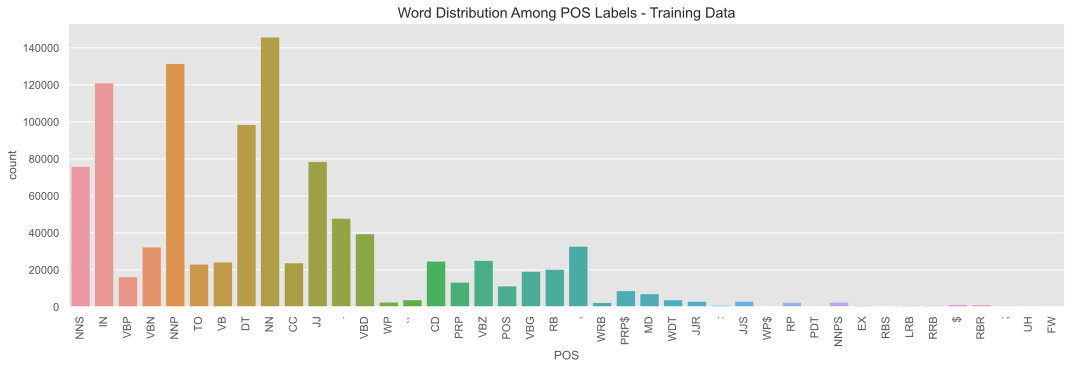

In [127]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='POS', data=data_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among POS Labels - Training Data")
plt.show()

### Checking Unique TAG labels

In [15]:
tag_values = list(set(data_train["Tag"].values))
print(tag_values)

['B-geo', 'O', 'I-org', 'I-per', 'B-eve', 'B-org', 'B-nat', 'B-tim', 'I-geo', 'B-art', 'B-gpe', 'I-tim', 'B-per', 'I-eve', 'I-nat', 'I-gpe', 'I-art']


**Note:** We are making labels as upper case to make them same format as the test data.

In [16]:
data_train['Tag'] = data_train['Tag'].str.upper()

In [17]:
tag_values = list(set(data_train["Tag"].values))
print(tag_values)

['I-ART', 'I-GEO', 'B-GEO', 'B-EVE', 'I-GPE', 'B-TIM', 'I-ORG', 'B-NAT', 'I-TIM', 'B-ART', 'O', 'I-EVE', 'B-ORG', 'I-PER', 'B-GPE', 'I-NAT', 'B-PER']


In [18]:
len(tag_values)

17

### Checking Label(Tag) Count 

In [19]:
label_counts = collections.Counter(list(data_train["Tag"].values))
print(label_counts)

Counter({'O': 887908, 'B-GEO': 37644, 'B-TIM': 20333, 'B-ORG': 20143, 'I-PER': 17251, 'B-PER': 16990, 'I-ORG': 16784, 'B-GPE': 15870, 'I-GEO': 7414, 'I-TIM': 6528, 'B-ART': 402, 'B-EVE': 308, 'I-ART': 297, 'I-EVE': 253, 'B-NAT': 201, 'I-GPE': 198, 'I-NAT': 51})


#### Word Distribution Among Tags

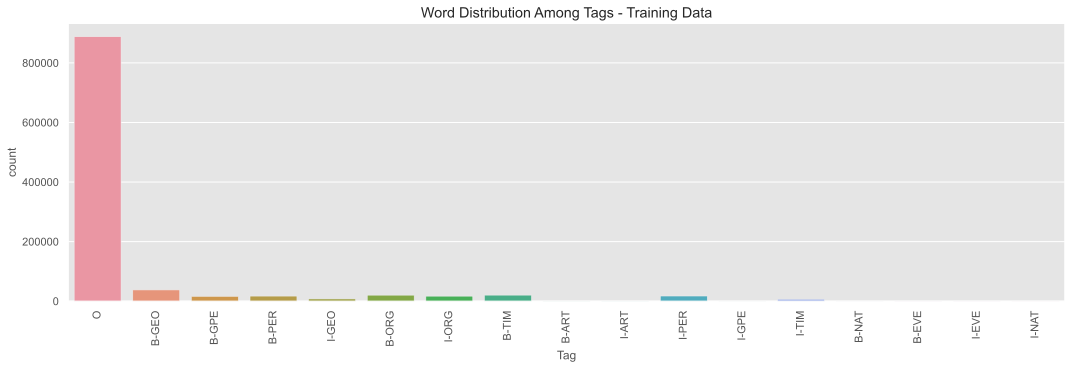

<Figure size 640x480 with 0 Axes>

In [109]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among Tags - Training Data")
plt.show()

#### Word Distribution Among Tags Without 0 Tag

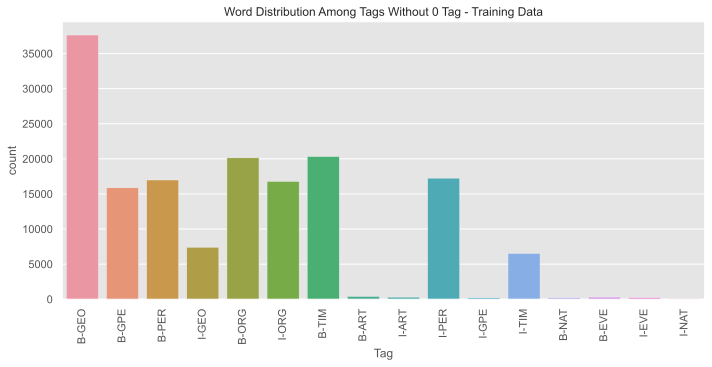

In [125]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Tag', data=data_train.loc[data_train['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among Tags Without 0 Tag - Training Data", fontsize=12)
plt.savefig('Word-Distribution-Among-Tags-Without-0-Training-Data.png', bbox_inches="tight")
plt.show()

### Getting Sentences as Units

In [22]:
# Function that processes the data into sentences
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [23]:
getter = SentenceGetter(data_train)

#### Example Sentence

In [24]:
sent = getter.get_next()

In [25]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-GEO'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-GEO'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-GPE'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


#### Get All The Sentences

In [26]:
sentences = getter.sentences

In [27]:
print(len(sentences))

47959


#### Sentence Distiributions By Length

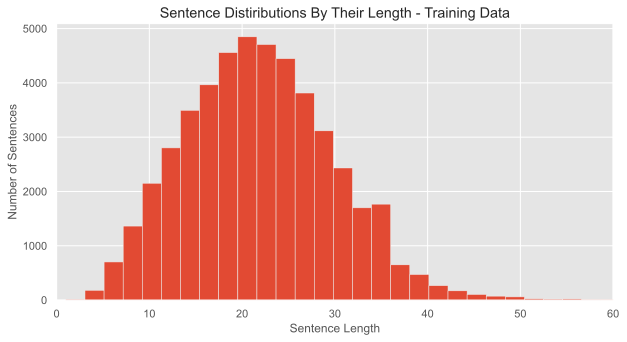

In [128]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlim(0, 60)
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences")
plt.title("Sentence Distiributions By Their Length - Training Data")
plt.show()

### Feature Engineering

In [29]:
# input is a sentence as a structure show above 
#and and ith word from the sentence to return the features for that word

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    # data structure consisting of a feature name and value for the token
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(), # lower case variant of the token
        'word[-3:]': word[-3:], #suffix of 3 characters
        'word[-2:]': word[-2:], #suffix of 2 characters
        'word.isupper()': word.isupper(), # initial captial
        'word.istitle()': word.istitle(), # all words ini caps
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2], #first two characters of the PoS Tag
    }
    if i > 0:
        # adding features for the word based on the previous word
        word1 = sent[i-1][0] # previous word
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True # Beginning of sentence as a feature

    if i < len(sent)-1:
        # adding features for the word based on the next word
        word1 = sent[i+1][0] # next word
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True # end of sentence as a feature

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

### Exctract Features For Training

In [30]:
X_train = [sent2features(s) for s in sentences]
y_train = [sent2labels(s) for s in sentences]

#### Inspect First Data Point

In [31]:
X_train[0]

[{'bias': 1.0,
  'word.lower()': 'thousands',
  'word[-3:]': 'nds',
  'word[-2:]': 'ds',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'NNS',
  'postag[:2]': 'NN',
  'BOS': True,
  '+1:word.lower()': 'of',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'IN',
  '+1:postag[:2]': 'IN'},
 {'bias': 1.0,
  'word.lower()': 'of',
  'word[-3:]': 'of',
  'word[-2:]': 'of',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'IN',
  'postag[:2]': 'IN',
  '-1:word.lower()': 'thousands',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'NNS',
  '-1:postag[:2]': 'NN',
  '+1:word.lower()': 'demonstrators',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'NNS',
  '+1:postag[:2]': 'NN'},
 {'bias': 1.0,
  'word.lower()': 'demonstrators',
  'word[-3:]': 'ors',
  'word[-2:]': 'rs',
  'word.isupper()': False,
  'word.istitle()': False,
  'wor

In [32]:
y_train[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GPE',
 'O',
 'O',
 'O',
 'O',
 'O']

## Training

#### Initialize CRF

In [33]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

#### Predict With 5 Folded Cross Validation

In [34]:
predict = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [35]:
report = flat_classification_report(y_pred=predict, y_true=y_train)
print(report)

              precision    recall  f1-score   support

       B-ART       0.37      0.11      0.17       402
       B-EVE       0.52      0.35      0.42       308
       B-GEO       0.85      0.90      0.88     37644
       B-GPE       0.97      0.94      0.95     15870
       B-NAT       0.66      0.37      0.47       201
       B-ORG       0.78      0.72      0.75     20143
       B-PER       0.84      0.81      0.82     16990
       B-TIM       0.93      0.88      0.90     20333
       I-ART       0.11      0.03      0.04       297
       I-EVE       0.34      0.21      0.26       253
       I-GEO       0.82      0.79      0.80      7414
       I-GPE       0.92      0.55      0.69       198
       I-NAT       0.61      0.27      0.38        51
       I-ORG       0.81      0.79      0.80     16784
       I-PER       0.84      0.89      0.87     17251
       I-TIM       0.83      0.76      0.80      6528
           O       0.99      0.99      0.99    887908

    accuracy              

#### Inspecting Features

In [36]:
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=100)

In [37]:
eli5.show_weights(crf, top=30)

From \ To,O,B-ART,I-ART,B-EVE,I-EVE,B-GEO,I-GEO,B-GPE,I-GPE,B-NAT,I-NAT,B-ORG,I-ORG,B-PER,I-PER,B-TIM,I-TIM
O,4.29,0.879,0.0,1.575,0.0,2.092,0.0,1.387,0.0,1.605,0.0,2.497,0.0,4.17,0.0,2.986,0.0
B-ART,-0.014,0.0,8.442,0.0,0.0,-0.398,0.0,0.0,0.0,0.0,0.0,0.516,0.0,-0.844,0.0,0.336,0.0
I-ART,-0.651,0.0,8.04,0.0,0.0,-0.702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.0,-0.684,0.0
B-EVE,-0.753,0.0,0.0,0.0,7.956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.572,0.0
I-EVE,-0.324,0.0,0.0,0.0,7.341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.621,0.0
B-GEO,0.677,0.752,0.0,0.545,0.0,0.0,8.752,0.579,0.0,0.0,0.0,1.155,0.0,1.143,0.0,2.344,0.0
I-GEO,-0.469,0.822,0.0,0.0,0.0,0.0,7.424,-1.366,0.0,0.0,0.0,-0.074,0.0,1.331,0.0,1.033,0.0
B-GPE,0.679,-1.609,0.0,-0.32,0.0,0.681,0.0,0.0,7.485,0.0,0.0,2.05,0.0,1.459,0.0,0.767,0.0
I-GPE,-0.298,0.0,0.0,0.0,0.0,-1.087,0.0,0.0,6.337,0.0,0.0,0.0,0.0,0.148,0.0,0.0,0.0
B-NAT,-1.108,0.0,0.0,0.0,0.0,0.625,0.0,0.0,0.0,0.0,7.067,0.0,0.0,-0.305,0.0,-0.413,0.0


In [38]:
print("precision-score: {:.1%}".format(precision_score(y_train, predict)))
print("recall-score: {:.1%}".format(recall_score(y_train, predict)))
print("F1-score: {:.1%}".format(f1_score(y_train, predict)))

precision-score: 84.6%
recall-score: 83.2%
F1-score: 83.9%


In [39]:
print(classification_report(y_train, predict))

              precision    recall  f1-score   support

         ART       0.36      0.10      0.16       402
         EVE       0.51      0.34      0.41       308
         GEO       0.85      0.90      0.87     37644
         GPE       0.97      0.94      0.95     15870
         NAT       0.65      0.36      0.47       201
         ORG       0.75      0.69      0.72     20143
         PER       0.77      0.75      0.76     16990
         TIM       0.90      0.86      0.88     20333

   micro avg       0.85      0.83      0.84    111891
   macro avg       0.72      0.62      0.65    111891
weighted avg       0.84      0.83      0.84    111891



## Prepare Test Dataset For Testing

### Read Dataset

In [47]:
data_test = pd.read_csv("NER-final-test.tsv", sep="\t", encoding="latin1")

In [48]:
data_test

,sentence id,token id,token,BIO NER tag
0,0,0,It,O
1,0,1,took,O
2,0,2,eight,O
3,0,3,years,O
4,0,4,for,O
...,...,...,...,...
209,9,12,get,O
210,9,13,into,O
211,9,14,this,O
212,9,15,one,O


### Checking Null Values

In [49]:
np.sum(data_test.isnull())

sentence id    0
token id       0
token          0
BIO NER tag    0
dtype: int64

### Modify Test Data to Same Shape as Train Data

#### Drop token id column

In [50]:
data_test = data_test.drop("token id", axis=1)

In [51]:
data_test

,sentence id,token,BIO NER tag
0,0,It,O
1,0,took,O
2,0,eight,O
3,0,years,O
4,0,for,O
...,...,...,...
209,9,get,O
210,9,into,O
211,9,this,O
212,9,one,O


#### Getting POS TAGS

In [52]:
# Create an empty list to store the processed documents
docs = []
pos_tag = []

# Iterate over the rows of the DataFrame
for index, row in data_test.iterrows():
    # Convert the token column to a string
    text = str(row["token"])
    # Tokenize the text using NLTK
    tokens = nltk.word_tokenize(text)
    # Tag the tokens using NLTK's POS tagger
    pos_tags = nltk.pos_tag(tokens)
    pos = [tag for token, tag in pos_tags]
    pos_tag.append(pos)
data_test["POS"] = pos_tag

In [53]:
print(data_test['POS'].dtype)

object


In [54]:
data_test.head()

,sentence id,token,BIO NER tag,POS
0,0,It,O,[PRP]
1,0,took,O,[VBD]
2,0,eight,O,[CD]
3,0,years,O,[NNS]
4,0,for,O,[IN]


In [55]:
data_test['POS'] = data_test['POS'].apply(lambda x: re.sub(r"[\'\"\[\],]", '', str(x)))

In [56]:
data_test.tail(10)

,sentence id,token,BIO NER tag,POS
204,9,but,O,CC
205,9,I,O,PRP
206,9,just,O,RB
207,9,could,O,MD
208,9,n't,O,RB
209,9,get,O,VB
210,9,into,O,IN
211,9,this,O,DT
212,9,one,O,CD
213,9,.,O,.


In [57]:
data_test = data_test.rename(columns={"sentence id" : "Sentence #", "token": "Word", "BIO NER tag": "Tag"})

In [58]:
data_test

,Sentence #,Word,Tag,POS
0,0,It,O,PRP
1,0,took,O,VBD
2,0,eight,O,CD
3,0,years,O,NNS
4,0,for,O,IN
...,...,...,...,...
209,9,get,O,VB
210,9,into,O,IN
211,9,this,O,DT
212,9,one,O,CD


In [59]:
data_test = data_test[['Sentence #', 'Word', 'POS', 'Tag']]

In [60]:
data_test

,Sentence #,Word,POS,Tag
0,0,It,PRP,O
1,0,took,VBD,O
2,0,eight,CD,O
3,0,years,NNS,O
4,0,for,IN,O
...,...,...,...,...
209,9,get,VB,O
210,9,into,IN,O
211,9,this,DT,O
212,9,one,CD,O


In [61]:
data_test['Sentence'] = 'Sentence: ' + (data_test['Sentence #'] + 1).astype(str)

/var/folders/g7/2byxjj8d5yj1_867l87ktyy00000gn/T/ipykernel_66208/566470779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Sentence'] = 'Sentence: ' + (data_test['Sentence #'] + 1).astype(str)


In [62]:
data_test = data_test.drop('Sentence #', axis=1)

In [63]:
data_test = data_test.rename(columns={"Sentence" : "Sentence #"})

In [64]:
data_test = data_test[['Sentence #', 'Word', "POS", 'Tag']]

In [65]:
data_test

,Sentence #,Word,POS,Tag
0,Sentence: 1,It,PRP,O
1,Sentence: 1,took,VBD,O
2,Sentence: 1,eight,CD,O
3,Sentence: 1,years,NNS,O
4,Sentence: 1,for,IN,O
...,...,...,...,...
209,Sentence: 10,get,VB,O
210,Sentence: 10,into,IN,O
211,Sentence: 10,this,DT,O
212,Sentence: 10,one,CD,O


### Continue on Exploring Test Dataset

In [66]:
words_test = list(set(data_test["Word"].values))

In [67]:
num_words_test = len(words_test)
num_words_test

142

### Checking Number of Sentences

In [68]:
data_test["Sentence #"].nunique()

10

### Checking Unique POS labels

In [69]:
pos_values_test = list(set(data_test["POS"].values))
print(pos_values_test)

['', '.', 'VBG', 'TO', 'VBZ', 'NNP', 'JJ', 'PRP$', 'WRB', 'MD', 'WP', 'PRP', 'DT', 'CC', 'CD', 'VB', ':', 'JJS', 'VBN', 'NN', 'RB', 'VBD', 'NNP .', 'NNS', 'IN']


In [70]:
len(pos_values_test)

25

#### Checking POS Counts

In [71]:
pos_label_counts_test = collections.Counter(list(data_test["POS"].values))
print(pos_label_counts_test)

Counter({'NN': 39, 'IN': 29, 'DT': 21, 'NNP': 14, 'PRP': 12, 'RB': 11, '.': 10, 'JJ': 9, 'NNS': 8, 'VBZ': 8, 'VB': 7, '': 7, 'CC': 6, 'VBN': 6, 'VBD': 5, 'PRP$': 5, 'TO': 4, 'CD': 3, 'MD': 2, 'VBG': 2, 'NNP .': 2, 'JJS': 1, ':': 1, 'WRB': 1, 'WP': 1})


#### Word Distribution Among POS

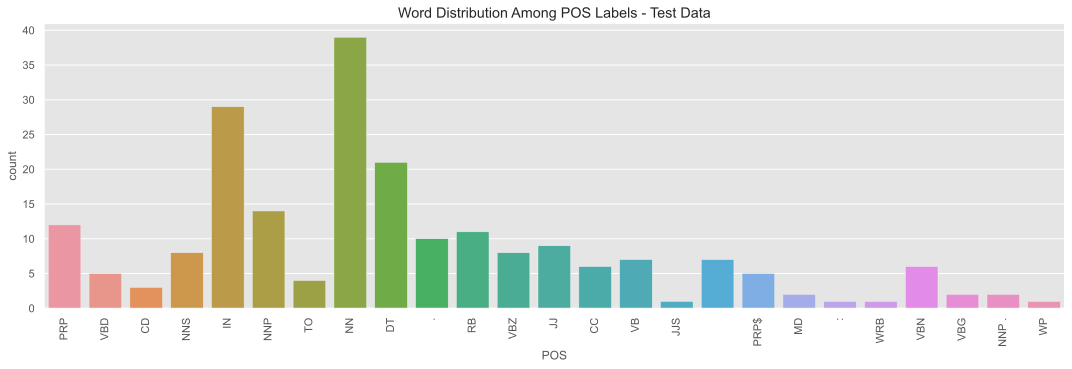

In [72]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='POS', data=data_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among POS Labels - Test Data")
plt.show()

### Checking Unique TAG labels

In [73]:
tag_values_test = list(set(data_test["Tag"].values))
print(tag_values_test)

['B-MISC', 'I-LOC', 'I-ORG', 'I-MISC', 'O', 'B-ORG', 'I-PER', 'B-LOC', 'B-PER']


In [74]:
len(tag_values_test)

9

### Checking Label(Tag) Count 

In [75]:
label_counts_test = collections.Counter(list(data_test["Tag"].values))
print(label_counts_test)

Counter({'O': 183, 'I-PER': 8, 'B-PER': 6, 'B-ORG': 4, 'B-LOC': 4, 'I-ORG': 3, 'B-MISC': 3, 'I-LOC': 2, 'I-MISC': 1})


#### Word Distribution Among Tags

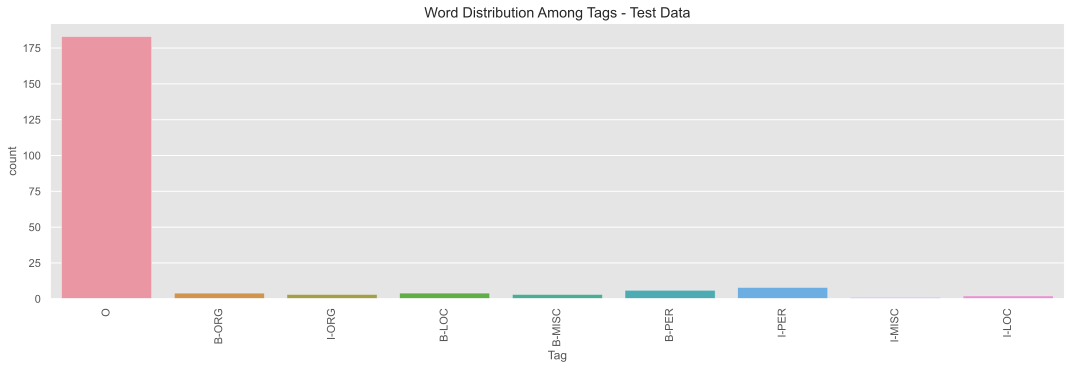

In [76]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among Tags - Test Data")
plt.show()

#### Word Distribution Among Tags Without 0 Tag

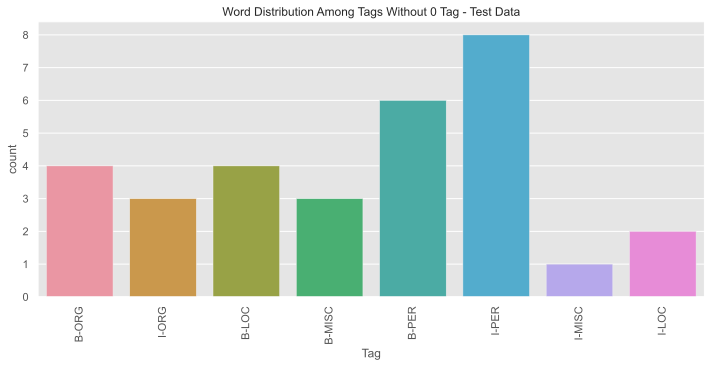

In [126]:
plt.figure(figsize=(10, 5)) # increase plot size to fit the title
ax = sns.countplot(x='Tag', data=data_test.loc[data_test['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Word Distribution Among Tags Without 0 Tag - Test Data", fontsize=12) # reduce font size of the title
plt.savefig('Word-Distribution-Among-Tags-Without-0-Test-Data.png', bbox_inches="tight")
plt.show()

### Getting Sentences as Units

In [78]:
getter_test = SentenceGetter(data_test)

#### Example Sentence

In [79]:
sent_test = getter_test.get_next()

In [80]:
print(sent_test)

[('It', 'PRP', 'O'), ('took', 'VBD', 'O'), ('eight', 'CD', 'O'), ('years', 'NNS', 'O'), ('for', 'IN', 'O'), ('Warner', 'NNP', 'B-ORG'), ('Brothers', 'NNS', 'I-ORG'), ('to', 'TO', 'O'), ('recover', 'NN', 'O'), ('from', 'IN', 'O'), ('the', 'DT', 'O'), ('disaster', 'NN', 'O'), ('that', 'IN', 'O'), ('was', 'VBD', 'O'), ('this', 'DT', 'O'), ('movie', 'NN', 'O'), ('.', '.', 'O')]


#### Get All The Sentences

In [81]:
sentences_test = getter_test.sentences

In [82]:
print(len(sentences_test))

10


#### Sentence Distiributions By Length

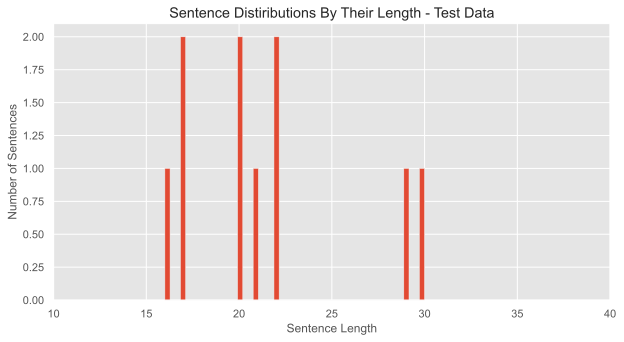

In [83]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sentences_test], bins=50)
plt.xlim(10, 40)
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences")
plt.title("Sentence Distiributions By Their Length - Test Data")
plt.show()

### Feature Engineering

### Exctract Features For Training

In [84]:
X_test = [sent2features(s) for s in sentences_test]
y_test = [sent2labels(s) for s in sentences_test]

In [85]:
len(X_test)

10

In [86]:
len(y_test)

10

#### Inspect First Data Point

In [87]:
X_test[0]

[{'bias': 1.0,
  'word.lower()': 'it',
  'word[-3:]': 'It',
  'word[-2:]': 'It',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'PRP',
  'postag[:2]': 'PR',
  'BOS': True,
  '+1:word.lower()': 'took',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'VBD',
  '+1:postag[:2]': 'VB'},
 {'bias': 1.0,
  'word.lower()': 'took',
  'word[-3:]': 'ook',
  'word[-2:]': 'ok',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'VBD',
  'postag[:2]': 'VB',
  '-1:word.lower()': 'it',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'PRP',
  '-1:postag[:2]': 'PR',
  '+1:word.lower()': 'eight',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'CD',
  '+1:postag[:2]': 'CD'},
 {'bias': 1.0,
  'word.lower()': 'eight',
  'word[-3:]': 'ght',
  'word[-2:]': 'ht',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'p

In [88]:
y_test[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

## Testing

In [89]:
labels = list(crf_tuning.classes_)

In [90]:
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-TIM',
 'B-ORG',
 'I-GEO',
 'B-PER',
 'I-PER',
 'I-ORG',
 'I-TIM',
 'B-ART',
 'I-ART',
 'B-NAT',
 'I-GPE',
 'I-NAT',
 'B-EVE',
 'I-EVE']

In [91]:
y_test

[['O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'I-ORG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'B-ORG',
  'I-ORG',
  'I-ORG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'O'],
 ['B-PER',
  'I-PER',


# TEST

In [94]:
y_pred_test_crf = crf.predict(X_test)
flat_f1_score(y_test, y_pred_test_crf,
                      average='weighted', labels=labels)

/Users/lionhunter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.9298479509105695

In [95]:
print(flat_classification_report(y_test, y_pred_test_crf))

              precision    recall  f1-score   support

       B-GEO       0.00      0.00      0.00         0
       B-GPE       0.00      0.00      0.00         0
       B-LOC       0.00      0.00      0.00         4
      B-MISC       0.00      0.00      0.00         3
       B-ORG       1.00      0.75      0.86         4
       B-PER       0.50      0.33      0.40         6
       B-TIM       0.00      0.00      0.00         0
       I-GEO       0.00      0.00      0.00         0
       I-LOC       0.00      0.00      0.00         2
      I-MISC       0.00      0.00      0.00         1
       I-ORG       1.00      0.67      0.80         3
       I-PER       1.00      0.38      0.55         8
           O       0.95      0.98      0.97       183

    accuracy                           0.89       214
   macro avg       0.34      0.24      0.27       214
weighted avg       0.90      0.89      0.89       214



/Users/lionhunter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lionhunter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lionhunter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lionh

In [97]:
print("precision-score: {:.1%}".format(precision_score(y_test, y_pred_test_crf)))
print("recall-score: {:.1%}".format(recall_score(y_test, y_pred_test_crf)))
print("F1-score: {:.1%}".format(f1_score(y_test, y_pred_test_crf)))

precision-score: 22.2%
recall-score: 23.5%
F1-score: 22.9%


In [105]:
crf.fit(X_test, y_test)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=100)

In [106]:
eli5.show_weights(crf, top=30)